In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from typing import Union
from tqdm.auto import tqdm as tqdm
from sklearn import preprocessing
import gc
import lightgbm as lgb
from hyperopt import hp
from tqdm import tqdm_notebook as tqdm
import random
import os
import re 
import lightgbm as lgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

In [2]:
data = pd.read_pickle('ca_model.pkl')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
ca_items = '[A-Z]+_\d{1}\d?_\d+_CA\w+'
sample_submission = sample_submission.loc[sample_submission['id'].str.contains(ca_items)]
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
'''Columns we can drop due to no importance'''

to_drop = ['is_quarter_start','is_quarter_end', 'is_year_start',
           'gap_placement', 'gap_size', 'gap_start',
           'number_of_gaps', 'is_month_start', 'is_year_end', 'is_month_end']

data.drop(to_drop, axis=1, inplace=True)

gc.collect()

In [4]:
features = [col for col in data.columns if col not in 'demand' or 'date']

x_train = data[data['date'] <= '2016-03-24']
y_train = x_train.sort_values('date')['demand']
x_val = data[(data['date'] > '2016-03-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-03-24')]
# product = data[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
gc.collect()

40

In [5]:
train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)
del x_train, y_train

In [6]:
from scipy.sparse import csr_matrix

sales_train_val = pd.read_csv('sales_train_validation.csv')
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = sample_submission.shape[1] - 1  # 28

weight_mat = np.c_[np.ones([NUM_ITEMS,1]).astype(np.int8), # level 1
                   pd.get_dummies(product.state_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.item_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str),drop_first=False).astype('int8').values,
                   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                   ].T


weight_mat_csr = csr_matrix(weight_mat)
del weight_mat; gc.collect()

def weight_calc(data,product):
    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount
    sales_train_val = pd.read_csv('sales_train_validation.csv')
    
    d_name = ['d_' + str(i+1) for i in range(1913)]

    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 1-1914のdayの数列のうち, 売上が存在しない日を一旦0にし、0を9999に置換。そのうえでminimum numberを計算
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))

    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))<1

    sales_train_val = np.where(flag,np.nan,sales_train_val)

    # denominator of RMSSE / RMSSEの分母
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no)

    # calculate the sales amount for each item/level
    df_tmp = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    df_tmp['amount'] = df_tmp['demand'] * df_tmp['sell_price']
    df_tmp =df_tmp.groupby(['id'])['amount'].apply(np.sum)
    df_tmp = df_tmp[product.id].values
    
    weight2 = weight_mat_csr * df_tmp 

    weight2 = weight2/np.sum(weight2)


    del sales_train_val
    gc.collect()
    
    return weight1, weight2

weight1, weight2 = weight_calc(data,product)


def wrmsse(preds, data):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values / 正解ラベル
    y_true = data.get_label()
    
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
    
          
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return 'wrmsse', score, False

def wrmsse_simple(preds, data):
    
    # actual obserbed values / 正解ラベル
    y_true = data.get_label()
    
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
          
    train = np.c_[reshaped_preds, reshaped_true]
    
    weight2_2 = weight2[:NUM_ITEMS]
    weight2_2 = weight2_2/np.sum(weight2_2)
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) /  weight1[:NUM_ITEMS])*weight2_2)
    
    return 'wrmsse', score, False

MemoryError: Unable to allocate array with shape (42840, 42840) and data type float64

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}

lgb_fit_params = {
    'early_stopping_rounds': 50,
    'verbose': False
}
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100, feval= wrmsse)
val_pred = model.predict(x_val[features])
    
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = np.sqrt(metrics.mean_squared_error(val_pred, y_val))

In [ ]:
class HPOpt(object):

    def __init__(self, train_set, val_set, x_val, y_val):
        self.train_set = train_set
        self.val_set   = val_set
        self.x_val     = x_val
        self.y_val     = y_val
  

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials


    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100, feval= wrmsse)
        val_pred = model.predict(x_val[features])
        val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
        return {'loss': val_score, 'status': STATUS_OK}

In [ ]:
obj = HPOpt(train_set, val_set, x_val, y_val)

lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#features based on detrended data

In [55]:
from itertools import cycle
%matplotlib inline
import matplotlib.pyplot as plt

colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def plot_item(item_id):
    '''Plot the selling history of "item" by day, month, and year.
    
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        matplotlib plot object of item sale history
    '''
    global item
    item = 'FOODS_3_090_CA_3_validation'
    
    item_df = data.loc[data['id'] == item_id][['bollinger','date']]

    fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
    item_df[['date', 'bollinger']].set_index('date').resample('D').mean()['bollinger'].plot(ax=axes, label='By day', alpha=0.8).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', 'bollinger']].set_index('date').resample('M').mean()['bollinger'].plot(ax=axes, label='By month', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', 'bollinger']].set_index('date').resample('Y').mean()['bollinger'].plot(ax=axes, label='By year', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    axes.set_title('Mean '+str(item_id)+ ' sold by hour, day and month', fontsize=16);
    axes.legend()

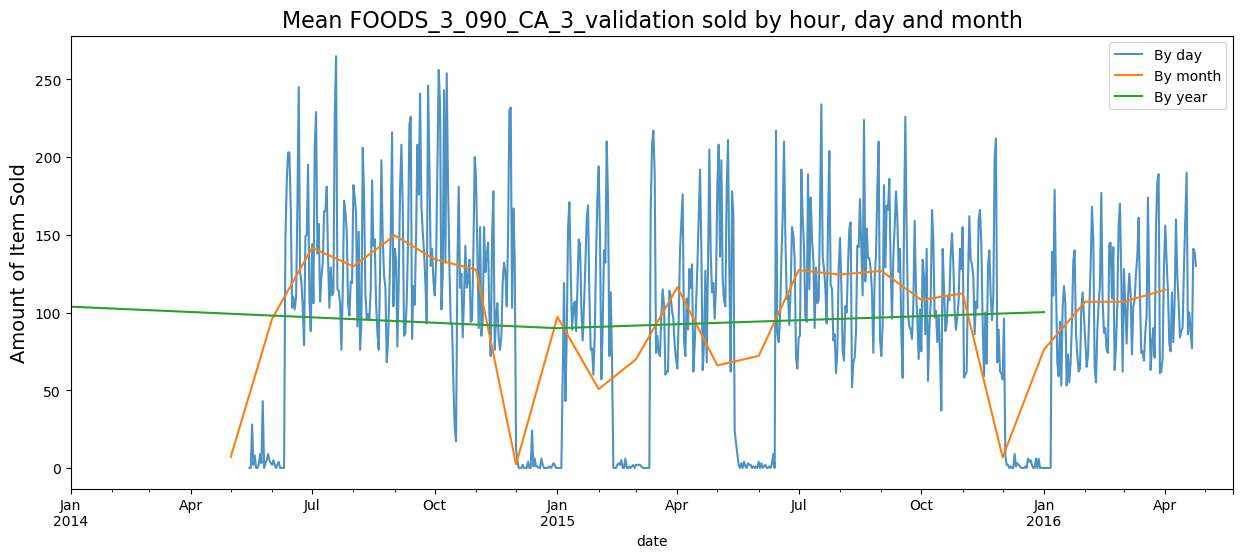

In [56]:
plot_item('FOODS_3_090_CA_3_validation')

In [91]:
from scipy.stats import linregress
a = np.squeeze(data.loc[data['id']=='FOODS_3_090_CA_3_validation']['bollinger'].T)
b = range(0,len(a))
linregress(a, b)

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)

In [52]:
cal = pd.read_csv('calendar.csv', parse_dates = ['date'])
sales = pd.read_csv('sales_train_validation.csv')
prices = pd.read_csv('sell_prices.csv')

In [57]:
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
d_cols = [col for col in sales.columns if 'd_' in col]

def plot_item1(item_id):
    '''Plot the selling history of "item" by day, month, and year.
    
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        matplotlib plot object of item sale history
    '''
    global item
    item = 'FOODS_3_090_CA_3_validation'
    
    item_df = sales.loc[sales['id'] == item_id][d_cols].T
    item_df = item_df.rename(columns={sales.index[sales['id']==item_id].to_list()[0]:item_id}) # Name it correctly
    item_df = item_df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    item_df = item_df.merge(cal, how='left', validate='1:1')

    fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
    item_df[['date', item_id]].set_index('date').resample('D').mean()[item_id].plot(ax=axes, label='By day', alpha=0.8).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', item_id]].set_index('date').resample('M').mean()[item_id].plot(ax=axes, label='By month', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', item_id]].set_index('date').resample('Y').mean()[item_id].plot(ax=axes, label='By year', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    axes.set_title('Mean '+str(item_id)+ ' sold by hour, day and month', fontsize=16);
    axes.legend()

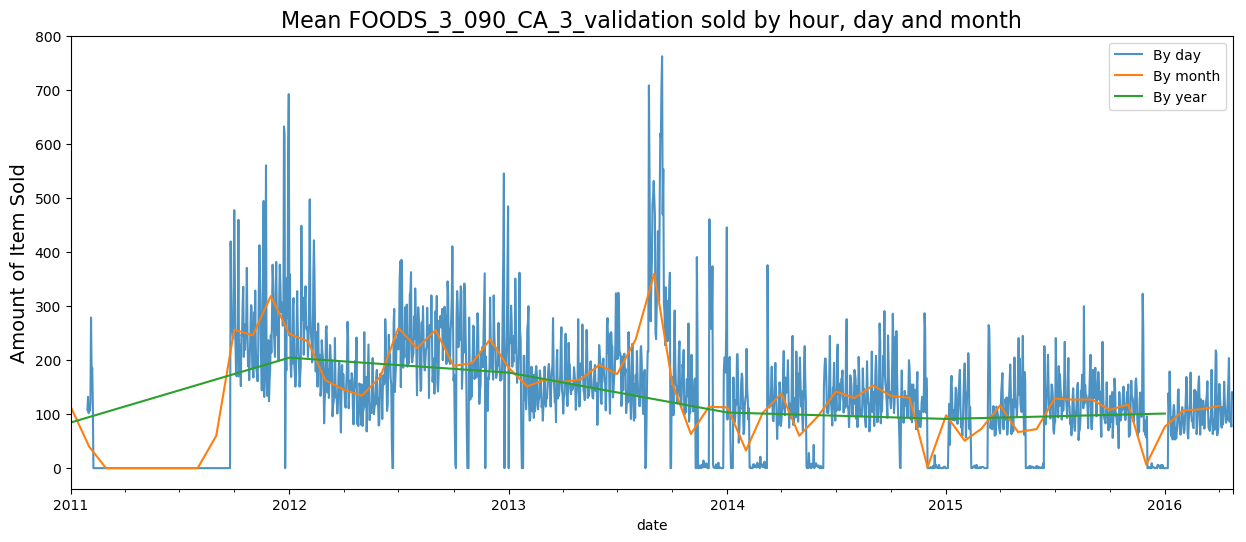

In [58]:
plot_item1('FOODS_3_090_CA_3_validation')

In [87]:
from scipy.stats import linregress
a = np.squeeze(sales.loc[sales['id']=='FOODS_3_090_CA_3_validation'][d_cols].T)
print(a[:4])
b = range(0,len(a))
print('slope of this item is: {}'.format(linregress(a, b)[0]))

d_1    108
d_2    132
d_3    102
d_4    120
Name: 8412, dtype: int64
slope of this item is: -0.5778787221537567
